In [1]:
from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import os
import gzip
import json
import time

import random
import collections
from collections import defaultdict

import scipy
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

In [2]:
from PIL import Image
import requests
from io import BytesIO

In [3]:
import implicit
from implicit.datasets.lastfm import get_lastfm

from implicit.als import AlternatingLeastSquares
from implicit.approximate_als import (AnnoyAlternatingLeastSquares, FaissAlternatingLeastSquares,
                                      NMSLibAlternatingLeastSquares)
from implicit.bpr import BayesianPersonalizedRanking

from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

In [4]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df_ = {}
    for d in parse(path):
        df_[i] = d
        i += 1
    return pd.DataFrame.from_dict(df_, orient='index')

In [5]:
# reviews_Toys_and_Games.json.gz
print("Loading Toys and Games Review dataset:")
print()
# _f = 'reviews_Toys_and_Games_5.json.gz'
_f = 'reviews_Toys_and_Games.json.gz'

start = time.time()
fd = getDF(_f)
print('Total time taken for loading the full toys and games reviews dataset : {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print("Number of records in 'Toys and Games Review' dataset: {:,}".format(len(fd)))
print()
print(fd.columns)

print()
fd.head(1)

Loading Toys and Games Review dataset:

Total time taken for loading the full toys and games reviews dataset : 2.0 minutes.

Number of records in 'Toys and Games Review' dataset: 2,252,771

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')



,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AMEVO2LY6VEJA,0000191639,Nicole Soeder,"[0, 0]","Great product, thank you! Our son loved the pu...",5.0,Puzzles,1388016000,"12 26, 2013"


In [6]:
# meta_Toys_and_Games.json.gz
print("Loading related metadata dataset:")
print()
# file = 'metadata.json.gz'
file = 'meta_Toys_and_Games.json.gz'
start = time.time()
fd_ = getDF(file)
print('Total time taken for loading the metadata dataset: {} minutes.'.format(np.round((time.time() - start)/60),2))
print()
print("Number of records in metadata dataset: {:,}".format(len(fd_)))
print()
print(fd_.columns)
print()
print(fd_.head(1))

Loading related metadata dataset:

Total time taken for loading the metadata dataset: 1.0 minutes.

Number of records in metadata dataset: 336,072

Index(['asin', 'description', 'title', 'price', 'salesRank', 'imUrl', 'brand',
       'categories', 'related'],
      dtype='object')

         asin                                        description  \
0  0000191639  Three Dr. Suess' Puzzles: Green Eggs and Ham, ...   

                                            title  price  \
0  Dr. Suess 19163 Dr. Seuss Puzzle 3 Pack Bundle  37.12   

                  salesRank  \
0  {'Toys & Games': 612379}   

                                               imUrl      brand  \
0  http://ecx.images-amazon.com/images/I/414PLROX...  Dr. Seuss   

                                  categories related  
0  [[Toys & Games, Puzzles, Jigsaw Puzzles]]     NaN  


In [7]:
start = time.time()

subcategory = 'Baby & Toddler Toys'

bttoys = fd_[fd_.categories.apply(lambda y: subcategory in y[0])]

print("Total time taken for filtering metadata dataset for 'Baby & Toddler Toys': {} secondss.".format(np.round((time.time() - start),2)))
print()
print("Number of records for sub-category 'Baby & Toddler Toys' in metadata dataset: {:,}".format(len(bttoys)))


Total time taken for filtering metadata dataset for 'Baby & Toddler Toys': 0.23 secondss.

Number of records for sub-category 'Baby & Toddler Toys' in metadata dataset: 5,085


In [8]:
print("Merging filtered Toys & Games dataset and the sub-category 'Baby & Toddler Toys' metadata dataset:")
print()
df = pd.merge(fd, bttoys, on=['asin'], how='inner')
print("Number of records for sub-category 'Baby & Toddler Toys' in the merged dataset: {:,}".format(len(df)))
print("Number of unique 'asin's  for sub-category 'Baby & Toddler Toys' in the merged dataset: {:,}".format(df.asin.nunique()))

Merging filtered Toys & Games dataset and the sub-category 'Baby & Toddler Toys' metadata dataset:

Number of records for sub-category 'Baby & Toddler Toys' in the merged dataset: 61,197
Number of unique 'asin's  for sub-category 'Baby & Toddler Toys' in the merged dataset: 5,017


In [9]:
df['date'] = pd.to_datetime(df['reviewTime'])
df['month'] = pd.to_datetime(df['reviewTime']).dt.month
df['year'] = pd.to_datetime(df['reviewTime']).dt.year

df.to_csv("df.csv", index=False)
cntByProduct = df[['asin','reviewText']].groupby('asin').agg('count')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,description,title,price,salesRank,imUrl,brand,categories,related,date,month,year
0,A1OGT7WHZJME26,141274475X,Amazon Customer,"[0, 0]","kids love it, we have read it over and over wi...",4.0,kids love it..,1390089600,"01 19, 2014",This Sesame Street Sound book: Rock and Roll w...,Karaoke Book Elmo,30.95,{'Toys & Games': 179057},http://ecx.images-amazon.com/images/I/517rnTTA...,NaN,"[[Toys & Games, Baby & Toddler Toys, Music & S...","{'also_bought': ['1412789958', '1412761352', '...",2014-01-19,1,2014
1,A31G4H8894N5S9,141274475X,es5065,"[2, 2]",Very disappointing! My baby loves this book bu...,2.0,Broke very easily,1377734400,"08 29, 2013",This Sesame Street Sound book: Rock and Roll w...,Karaoke Book Elmo,30.95,{'Toys & Games': 179057},http://ecx.images-amazon.com/images/I/517rnTTA...,NaN,"[[Toys & Games, Baby & Toddler Toys, Music & S...","{'also_bought': ['1412789958', '1412761352', '...",2013-08-29,8,2013
2,A3ATTKX4QXH4FF,141274475X,Laura,"[0, 0]",This is a GREAT book! My kids love it. I esp...,3.0,"Great book, uses batteries like crazy",1403308800,"06 21, 2014",This Sesame Street Sound book: Rock and Roll w...,Karaoke Book Elmo,30.95,{'Toys & Games': 179057},http://ecx.images-amazon.com/images/I/517rnTTA...,NaN,"[[Toys & Games, Baby & Toddler Toys, Music & S...","{'also_bought': ['1412789958', '1412761352', '...",2014-06-21,6,2014
3,A2B9TZVGLVQHH9,141274475X,Shirley H.,"[0, 0]",I bought this item in February for my Grandson...,3.0,Disappointed,1399334400,"05 6, 2014",This Sesame Street Sound book: Rock and Roll w...,Karaoke Book Elmo,30.95,{'Toys & Games': 179057},http://ecx.images-amazon.com/images/I/517rnTTA...,NaN,"[[Toys & Games, Baby & Toddler Toys, Music & S...","{'also_bought': ['1412789958', '1412761352', '...",2014-05-06,5,2014
4,A1I1OIMRX68OGC,3869140011,"cushmom ""b""","[0, 0]",I was expecting a little bit bigger toy for th...,3.0,Baby bath book,1392508800,"02 16, 2014",Kids will love going on underwater adventures ...,Haba Bath Book Penguin,17.99,{'Toys & Games': 494693},http://ecx.images-amazon.com/images/I/511N1E6P...,NaN,"[[Toys & Games, Baby & Toddler Toys, Bath Toys]]","{'also_bought': ['3869140003'], 'bought_togeth...",2014-02-16,2,2014


In [10]:
# Create a numeric user_id and artist_id column
data = pd.DataFrame(columns=['user', 'item', 'rating'])
data['rating'] = df['overall']
data['user'] = df['reviewerID'].astype("category")
data['item'] = df['asin'].astype("category")
# convert raw ids of the 'item's to 'item_id' that assigns categorical values
data['user_id'] = data['user'].cat.codes
data['item_id'] = data['item'].cat.codes

In [11]:
# The implicit library expects data as a item-user matrix so we
# create two matrices, one for fitting the model (item-user) and the other for recommendations (user-item)
sparse_item_user = sparse.csr_matrix((data['rating'].astype(float), (data['item_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['rating'].astype(float), (data['user_id'], data['item_id'])))

In [12]:
# Initialize the als model and fit it using the sparse item-user matrix
start = time.time()
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
data_conf = (sparse_item_user * alpha_val).astype('double')

#Fit the model
model.fit(data_conf)
print("time taken to fit the ALS model:", np.round((time.time() - start),2))

100%|██████████| 20.0/20 [00:00<00:00, 74.92it/s]

time taken to fit the ALS model: 0.29


In [13]:
print("number of records in data: {:,}".format(len(data['item_id'].values)))
print("number of unique 'item_id's in data: {:,}".format(len(set(data['item_id'].values))))

number of records in data: 61,197
number of unique 'item_id's in data: 5,017


In [16]:
# Use implicit to get similar items.
n_similar = 10
similar_items = {}
for item_id in data['item_id'].values:
#     print(data['item_id'].values)
    similar_items[item_id] = model.similar_items(item_id, n_similar)   

In [17]:
# Print the names of our most similar items
start = time.time()
similar_items_raw = {}
neighbors = {}
for key, val in similar_items.items():
    sim = []
    item_neighbors = []
    for i in range(10):
        idx, score = val[i]
#         print("item_id = ", idx, "raw_item = ", data.item.loc[data.item_id == idx].iloc[0])
        sim.append((data.item.loc[data.item_id == idx].iloc[0],score))
        item_neighbors.append(data.item.loc[data.item_id == idx].iloc[0])
    similar_items_raw[data.item.loc[data.item_id == key].iloc[0]] = sim
    neighbors[data.item.loc[data.item_id == key].iloc[0]] = item_neighbors
print("time taken to compute similarity matrix with raw ids:", np.round((time.time() - start),2), "seconds")

time taken to compute similarity matrix with raw ids: 35.79 seconds


In [19]:
from collections import Counter
d = Counter(x for sublist in neighbors.values() for x in sublist)
print("Minimum recommended item:", min(d, key=d.get), "with", min(d.values()))
print("Maximum recommended item:", max(d, key=d.get), "with", max(d.values()))

Minimum recommended item: B00001U0RG with 1
Maximum recommended item: B0044UUWS2 with 36


In [20]:
# Check to see if all items form part of similarity calculations
print(len(neighbors))
print(len(Counter(x for sublist in neighbors.values() for x in sublist)))

5017
5017


In [21]:
if os.path.isfile("neighbors_baby.json"):
    pass
#     neighbors_baby = pd.read_csv("neighbors_baby.json", index=False)
else:
    with open("neighbors_baby.json", 'w') as f:
        json.dump(neighbors, f)

Product 141274475X 
	 807    This Sesame Street Sound book: Rock and Roll w...
Name: description, dtype: object 
	 807    Karaoke Book Elmo
Name: title, dtype: object


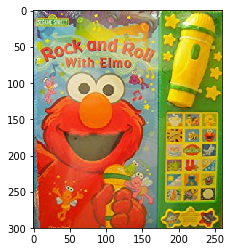

Similar items:
	---Product 141274475X 	 similarity score: 0.011874737 
 807    This Sesame Street Sound book: Rock and Roll w...
Name: description, dtype: object 
	 807    Karaoke Book Elmo
Name: title, dtype: object


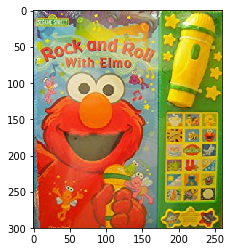


	---Product B005LRTTY0 	 similarity score: 0.010964067 
 219895    Great stacking cups for the bath with amusing ...
Name: description, dtype: object 
	 219895    International Playthings Stacking Faces
Name: title, dtype: object


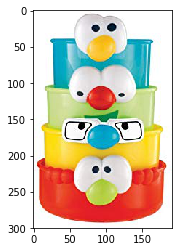


	---Product B0015YXD40 	 similarity score: 0.010865198 
 87390    Megcos Toy Company Ltd, educational products i...
Name: description, dtype: object 
	 87390    megcos Musical Zoo Plays 42 Songs
Name: title, dtype: object


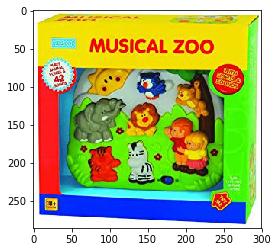


	---Product B007IKT5VK 	 similarity score: 0.009746291 
 247377    Let your imagination soar with these ducks! Ge...
Name: description, dtype: object 
	 247377    12 ct - Pilot Aviator Rubber Ducks
Name: title, dtype: object


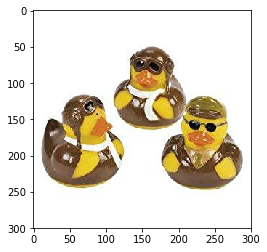


	---Product B0041UA8M0 	 similarity score: 0.008077247 
 174393    Soft, stain resistant books for infants and to...
Name: description, dtype: object 
	 174393    Scooby-doo Bath Books (Set of 2)
Name: title, dtype: object


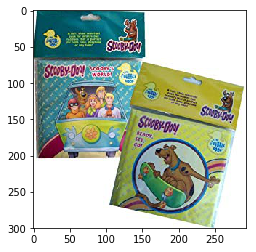


	---Product B00GKFVAZI 	 similarity score: 0.0078759 
 325299    Operating Instructions:Any key you press or st...
Name: description, dtype: object 
	 325299    Top Seller Funny Baby Piano Music Fish Animal ...
Name: title, dtype: object


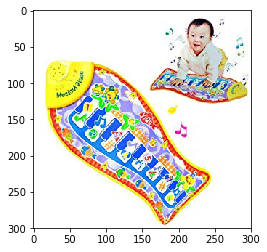


	---Product B0013J2JW4 	 similarity score: 0.007588759 
 83775    Sock Monkey Jack-In-The-Box is a great additio...
Name: description, dtype: object 
	 83775    Sock Monkey Jack in the Box
Name: title, dtype: object


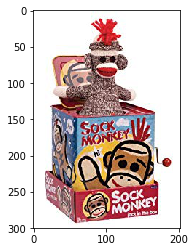


	---Product B00C2SJ92I 	 similarity score: 0.007344409 
 298672    Take your favorite Nickelodeon's Bubble Guppie...
Name: description, dtype: object 
	 298672    Fisher-Price Nickelodeon's Bubble Guppies Moll...
Name: title, dtype: object


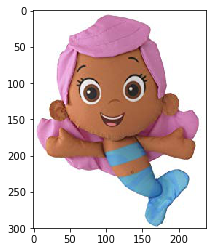


	---Product B000JCE4MO 	 similarity score: 0.0073100585 
 50205    This happy little Teddy is ready for on-the-go...
Name: description, dtype: object 
	 50205    Tolo Toys Push and Go Teddy
Name: title, dtype: object


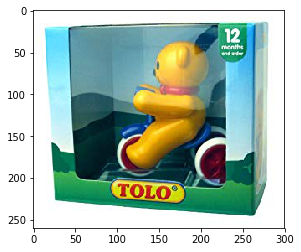


	---Product B008YD3MHS 	 similarity score: 0.0072721164 
 267869    Race around with the Bubble Guppies. This set ...
Name: description, dtype: object 
	 267869    Fisher-Price Nickelodeon Bubble Guppies: Gil &...
Name: title, dtype: object


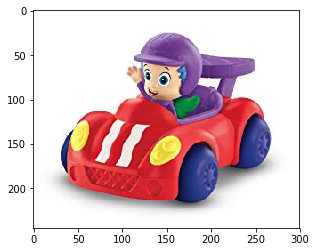


Product B00LLH2BX0 
	 336059    "Wet & Stick" little builder, board and blocks...
Name: description, dtype: object 
	 336059    Edushape Floating Blocks - Includes 15 Foam Bl...
Name: title, dtype: object


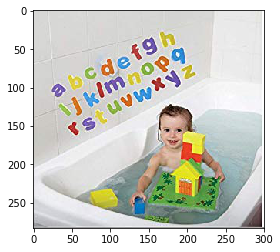

Similar items:
	---Product B00LLH2BX0 	 similarity score: 2.0241732e-10 
 336059    "Wet & Stick" little builder, board and blocks...
Name: description, dtype: object 
	 336059    Edushape Floating Blocks - Includes 15 Foam Bl...
Name: title, dtype: object


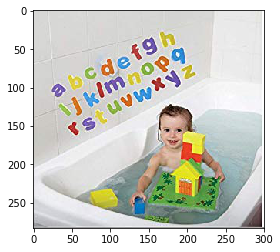


	---Product B003XSCZUE 	 similarity score: 1.7526187e-10 
 170702    Let's Learn Time and Money bundle is a unique ...
Name: description, dtype: object 
	 170702    Let's Learn Time and Money Teaching Time Clock...
Name: title, dtype: object


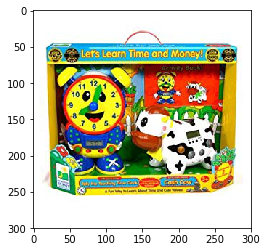


	---Product B00B4WJME8 	 similarity score: 1.7197657e-10 
 289786    Aurora World's Brunette Ballerina Doll is 14.5...
Name: description, dtype: object 
	 289786    Aurora World Brunette Ballerina 14.5&quot; Plush
Name: title, dtype: object


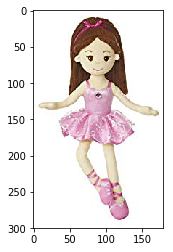


	---Product B000E4C54Q 	 similarity score: 1.706774e-10 
 36256    Portable musical toy that will play 6 entertai...
Name: description, dtype: object 
	 36256    MP 123 Player
Name: title, dtype: object


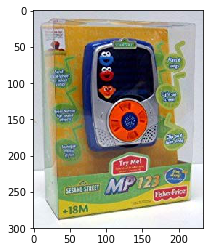


	---Product B002GFA9G2 	 similarity score: 1.706606e-10 
 129385    Disney 4-pc. My Friends Tigger & Pooh Bath Toy...
Name: description, dtype: object 
	 129385    Disney 4-pc. My Friends Tigger &amp; Pooh Bath...
Name: title, dtype: object


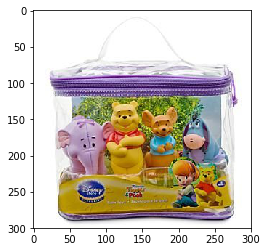


	---Product B006UIR2F2 	 similarity score: 1.6955136e-10 
 237624    Mr. Bubble has continued to be trusted by moms...
Name: description, dtype: object 
	 237624    Mr. Bubble Bubble Boat
Name: title, dtype: object


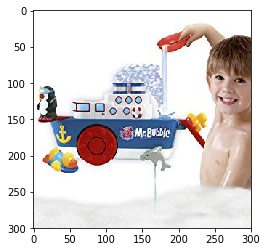


	---Product B00004W157 	 similarity score: 1.6317547e-10 
 5376    When the food scene stretches from a deep-spac...
Name: description, dtype: object 
	 5376    Small World Toys Gourmet Kitchen Set
Name: title, dtype: object


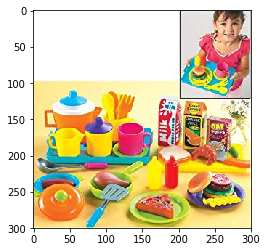


	---Product B008MTYU70 	 similarity score: 1.6253575e-10 
 264291    Little Tikes PopTunes are musical toy instrume...
Name: description, dtype: object 
	 264291    Little Tikes PopTunes Drum
Name: title, dtype: object


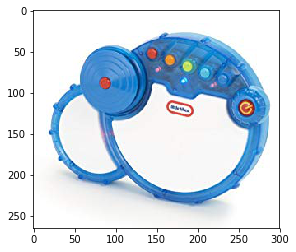


	---Product B00HD0JH6S 	 similarity score: 1.6014916e-10 
 328720    http://www.youtube.com/watch?v=G5zXroLZaDQ
Name: description, dtype: object 
	 328720    Robocar Poli Deluxe Transformer Toy - Heli
Name: title, dtype: object


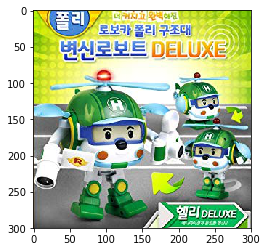


	---Product B0006JKVU4 	 similarity score: 1.5739104e-10 
 19318    TOMY Quack Along Ducks is a pull-along toy des...
Name: description, dtype: object 
	 19318    TOMY Quack Along Ducks
Name: title, dtype: object


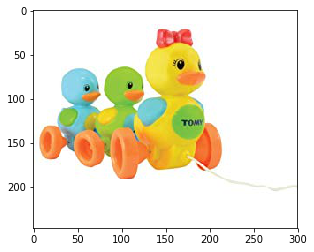

In [24]:
# Visualize two items: the first and the last items:
import matplotlib.pyplot as plt
main_item = list(similar_items_raw.keys())[0]
print("Product", main_item, "\n\t", fd_[fd_['asin'] == main_item]['description'], "\n\t", fd_[fd_['asin'] == main_item]['title'])

response = requests.get(fd_[fd_['asin'] == main_item]['imUrl'].values[0])
img = Image.open(BytesIO(response.content))

imgplot = plt.imshow(img)
plt.show()

# similar_items = neighbors.get(val)

print("Similar items:")
for i in range(10):
    idx, score = similar_items_raw[main_item][i]
    print("\t---Product", idx, "\t", "similarity score:", score, "\n", fd_[fd_['asin'] == idx]['description'], "\n\t", fd_[fd_['asin'] == idx]['title'])
    response = requests.get(fd_[fd_['asin'] == idx]['imUrl'].values[0])
    img = Image.open(BytesIO(response.content))
    imgplot = plt.imshow(img)
    plt.show()
    print()
    
# main_itm = next(iter(similar_items_raw.keys()))
main_itm = list(similar_items_raw.keys())[-1]
print("Product", main_itm, "\n\t", fd_[fd_['asin'] == main_itm]['description'], "\n\t", fd_[fd_['asin'] == main_itm]['title'])

response = requests.get(fd_[fd_['asin'] == main_itm]['imUrl'].values[0])
img = Image.open(BytesIO(response.content))

imgplot = plt.imshow(img)
plt.show()

# similar_items = neighbors.get(val)

print("Similar items:")
for i in range(10):
    idx, score = similar_items_raw[main_itm][i]
    print("\t---Product", idx, "\t", "similarity score:", score, "\n", fd_[fd_['asin'] == idx]['description'], "\n\t", fd_[fd_['asin'] == idx]['title'])
    response = requests.get(fd_[fd_['asin'] == idx]['imUrl'].values[0])
    img = Image.open(BytesIO(response.content))
    imgplot = plt.imshow(img)
    plt.show()
    print()